In [ ]:
#Mounting Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
#Import data from google drive
data = pd.read_csv('/content/drive/MyDrive/ML_Datasets/loan.csv',skiprows=1)
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,NaN,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,NaN,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,NaN,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,NaN,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21%,37.0,f,0.0,0.0,12231.890000,12231.89,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Fully Paid,n,NaN,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9%,38.0,f,0.0,0.0,4066.908161,4066.91,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42533,NaN,NaN,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,NaN,< 1 year,RENT,110000.0,Not Verified,Jun-2007,Does not meet the credit pol

# **Data Prepration and Cleaning**

---


In [ ]:
#selection of necessary columns for our analysis
df = data.filter(['loan_amnt','int_rate','emp_length','home_ownership',
                    'annual_inc','purpose','addr_state','dti','loan_status'])
df.dtypes

loan_amnt         float64
int_rate           object
emp_length         object
home_ownership     object
annual_inc        float64
purpose            object
addr_state         object
dti               float64
loan_status        object
dtype: object

In [ ]:
#changing int_rate to float
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0

In [ ]:
## dropping the null rows since we have sufficient amount of data and there is no need to fill the null values.
df.dropna(axis=0, inplace=True)

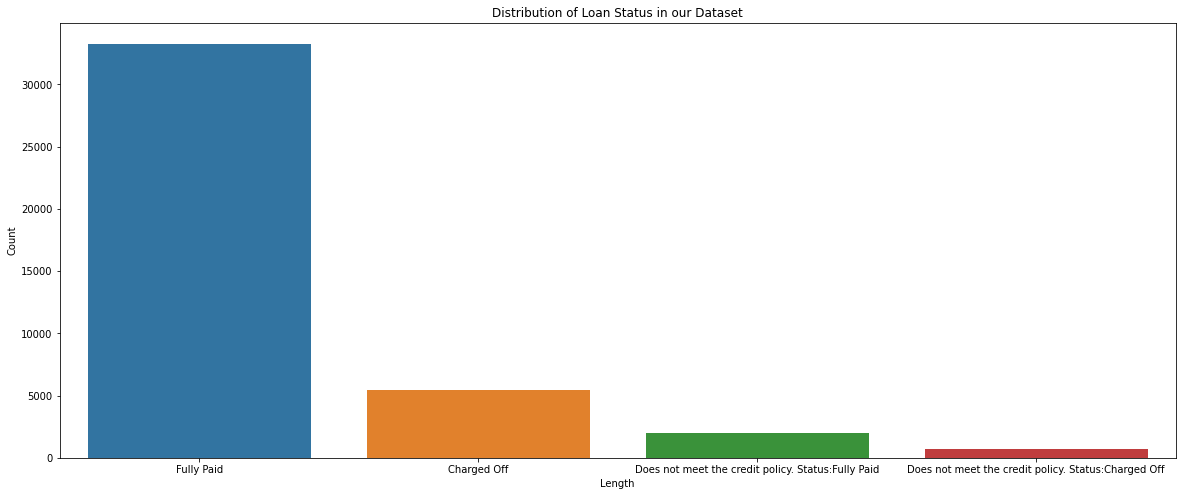

In [ ]:
m =df['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(20,8))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset")
plt.show()

# **Transformation**


In [ ]:
X = df.iloc [:, :-1].values
y = df.iloc [:, -1].values

X

array([[5000.0, 0.1065, '10+ years', ..., 'credit_card', 'AZ', 27.65],
       [2500.0, 0.1527, '< 1 year', ..., 'car', 'GA', 1.0],
       [2400.0, 0.15960000000000002, '10+ years', ..., 'small_business',
        'IL', 8.72],
       ...,
       [1000.0, 0.0964, '< 1 year', ..., 'other', 'MA', 10.0],
       [2525.0, 0.0933, '< 1 year', ..., 'other', 'NY', 10.0],
       [5000.0, 0.0775, '10+ years', ..., 'other', 'CT', 8.81]],
      dtype=object)

In [ ]:
y

array(['Fully Paid', 'Charged Off', 'Fully Paid', ...,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Fully Paid'], dtype=object)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([3, 0, 3, ..., 2, 2, 2])

In [ ]:
X[:, 2] = le.fit_transform(X[:, 2])
X[:, 3] = le.fit_transform(X[:, 3])
X[:, 5] = le.fit_transform(X[:, 5])
X[:, 6] = le.fit_transform(X[:, 6])

X

array([[5000.0, 0.1065, 1, ..., 1, 3, 27.65],
       [2500.0, 0.1527, 10, ..., 0, 10, 1.0],
       [2400.0, 0.15960000000000002, 1, ..., 11, 14, 8.72],
       ...,
       [1000.0, 0.0964, 10, ..., 9, 19, 10.0],
       [2525.0, 0.0933, 10, ..., 9, 33, 10.0],
       [5000.0, 0.0775, 1, ..., 9, 6, 8.81]], dtype=object)

In [ ]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 17)

In [ ]:
#standarization of the parameters
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units= 20, activation='relu'))
ann.add(tf.keras.layers.Dense(units= 40, activation= 'relu'))
ann.add(tf.keras.layers.Dense(units= 80, activation= 'relu'))
ann.add(tf.keras.layers.Dense(units=4, activation='softmax'))
ann.compile(loss = 'sparse_categorical_crossentropy', 
                      optimizer = 'adam', 
                      metrics = ['accuracy'])

In [ ]:
res=ann.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5333 - accuracy: 0.8121
Epoch 2/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5328 - accuracy: 0.8113
Epoch 3/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5326 - accuracy: 0.8121
Epoch 4/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5324 - accuracy: 0.8115
Epoch 5/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5311 - accuracy: 0.8125
Epoch 6/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5314 - accuracy: 0.8123
Epoch 7/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5318 - accuracy: 0.8118
Epoch 8/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5316 - accuracy: 0.8118
Epoch 9/100
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5298 - accuracy: 0.8124
Epoch 10/100
1036/1036 [==============================] - 2s 2ms/step - l

In [ ]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    #plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    #plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy score evolution during trainig')
    plt.legend()


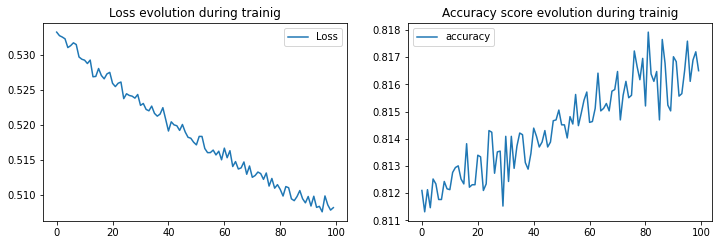

In [ ]:
plot_learning_evolution(res)

In [ ]:
X[5869]

array([3100.0, 0.0751, 5, 0, 32000.0, 1, 33, 17.55], dtype=object)

In [ ]:
print(ann.predict(sc.transform([[3100.0, 0.0751, 5, 0, 32000.0, 1, 33, 17.55]])) > 0.5)

[[False False False  True]]
